In [1]:
import torch
from torch.autograd import Variable
import time
import numpy as np
from maddpg.utils.buffer import ReplayBuffer, ReplayBuffer_CNN
from maddpg.algorithms.maddpg import MADDPG

from pettingzoo.classic import connect_four_v3

from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams.update({'axes.labelsize':16, 'xtick.labelsize':13, 'ytick.labelsize':13, 'legend.fontsize':14, 'legend.title_fontsize':14, 
                     'figure.titlesize':16, 'axes.titlesize': 14, "font.size":14, 'figure.figsize': (20,5), 'lines.linewidth': 1, 
                     'lines.linestyle': '-'})

In [2]:
def plot(frame_idx, scores, save_pic=False):
    clear_output(True)
    plt.figure(figsize=(24, 5))
   
    mean_score = 0
    colors = ['b', 'm', 'c', 'g', 'y']
    for i, sc in enumerate(scores):
        mean_score += np.mean(scores[sc][-20:])
        plt.plot(np.cumsum(scores[sc]), colors[i], linewidth=1, label=sc)   
    plt.title(f"frame {frame_idx}. score: {mean_score:.2f}")
    plt.axhline(y=0.0, color='grey', linestyle='--')
    plt.legend()
    if save_pic:
        plt.savefig(f'results_eps-{frame_idx}_{(time.asctime()[4:16].replace(":","-"))}.png')
    plt.show()
    
def dic_builder(num_walkers, value):
    return {f'agent_{n}':deepcopy(value) for n in range(num_walkers)}

In [3]:
env = connect_four_v3.env()
print(env.observation_spaces['player_0']['action_mask'].shape)
print(env.observation_spaces['player_0']['observation'].shape)
print(env.action_spaces['player_0'].n)

(7,)
(6, 7, 2)
7


In [4]:
[(7,),(6, 7, 2)]

[(7,), (6, 7, 2)]

In [5]:
USE_CUDA = True
MODEL_DIR = 'models/'
LOG_DIR = 'logs/'
AGENT_ALG = "MADDPG"
ADVERSARY_ALG = "DDPG"
TAU = 0.01
LR = 0.002
HIDDEN_DIM = 50
BUFFER_LENGTH = int(1e4)
BATCH_SIZE = 1024
# OBS_DIM = (lambda x: x[0]*x[1]*x[2])(env.observation_spaces['player_0']['observation'].shape)
OBS_DIM = env.observation_spaces['player_0']['observation'].shape[::-1] # first is channel
ACT_DIM = env.action_spaces['player_0'].n

Init_noise_scale = 0.5
Final_noise_scale = 0.1
SAVE_INTERVAL = 500
Plot_interval = 5

EPISODE_LEN = 500
Steps_per_update = 5
N_rollout_threads = 1
N_training_threads = 1  # how much times to train in 1 step
N_EPISODES = 50000
N_exploration_eps = 20000
N_AGENTS = 2

In [6]:
agent_params = {'num_in_pol': OBS_DIM, 'num_out_pol': ACT_DIM, 
                'num_in_critic': (np.prod(OBS_DIM)+ACT_DIM) * N_AGENTS if AGENT_ALG == 'MADDPG' else 1}

maddpg = MADDPG(agent_init_params=[deepcopy(agent_params) for _ in range(N_AGENTS)],
                alg_types=[deepcopy(AGENT_ALG) for _ in range(N_AGENTS)],
                tau=TAU, lr=LR, hidden_dim=HIDDEN_DIM, discrete_action=True)

In [7]:
replay_buffer = ReplayBuffer_CNN(BUFFER_LENGTH, N_AGENTS, [deepcopy(OBS_DIM) for _ in range(N_AGENTS)], [deepcopy(ACT_DIM) for _ in range(N_AGENTS)])
logger = None

def rewards_prep(rewards, t_i):
    for i in range(t_i-1, -1, -1):
        rewards[i] += rewards[i+1] * 0.9
    return rewards

# Training

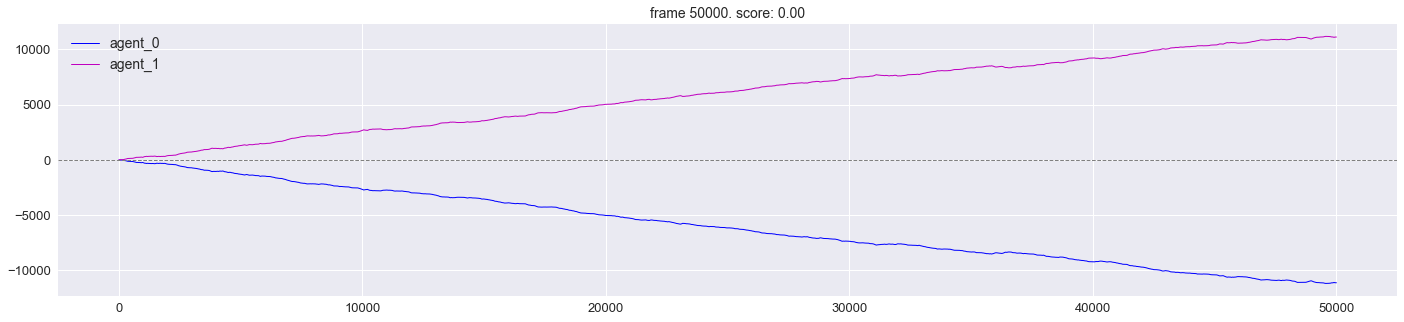

training took 225.9182312210401 min!


In [81]:
avg_score = np.zeros((N_AGENTS))
best_score = 0
scores = dic_builder(N_AGENTS, [])
t0 = time.time()
for ep_i in range(0, N_EPISODES):
    env.reset()
    states = np.zeros((22, N_AGENTS) + OBS_DIM)
    actions = np.zeros((22, N_AGENTS, ACT_DIM))
    rewards = np.zeros((22, N_AGENTS))
    next_states = np.zeros((22, N_AGENTS) + OBS_DIM)
    dones = np.zeros((22, N_AGENTS))
    round_score = np.zeros((N_AGENTS))
    next_obs = [deepcopy(0) for _ in range(N_AGENTS)]
    
    # obs.shape = (n_rollout_threads, nagent)(nobs), nobs differs per agent so not tensor
    maddpg.prep_rollouts(device='cpu')

    explr_pct_remaining = max(0, N_exploration_eps - ep_i) / N_exploration_eps
    maddpg.scale_noise(Final_noise_scale + (Init_noise_scale - Final_noise_scale) * explr_pct_remaining)
    maddpg.reset_noise()

    for t, wlkr in enumerate(env.agent_iter()):
        i_a = t % N_AGENTS
        t_i = t // 2
        next_obs[i_a], rewards[t_i, i_a], dones[t_i, i_a], _ = env.last()
        next_states[t_i, i_a] = np.swapaxes(next_obs[i_a]['observation'], 0, 2)
        
        if dones[t_i, i_a]:
#             print(f'{dones[t_i] = }; {rewards[t_i] = }; {actions[t_i-1:t_i, (i_a+1)%2] = }')
            env.step(None)
            continue
        
#         if i_a == N_AGENTS - 1: # saving info once in cycle of agents moves
#             replay_buffer.push(states, actions, rewards, next_states, dones)
        states[t_i, i_a] = deepcopy(next_states[t_i, i_a])
        
        torch_obs = Variable(torch.Tensor(next_states[t_i:t_i+1, i_a]), requires_grad=False)
        torch_mask = Variable(torch.Tensor((next_obs[i_a]['action_mask']-1) * 5 ), requires_grad=False)
        # get actions as torch Variables
        torch_agent_actions = maddpg.step(torch_obs, torch_mask, i_a, explore=True)
        # convert actions to numpy arrays
        actions[t_i, i_a] = deepcopy(torch_agent_actions.data.numpy())
        env.step(np.argmax(actions[t_i, i_a]))
        
    
        # training
        if (len(replay_buffer) >= BATCH_SIZE and
            ((ep_i+1) % Steps_per_update) == 0):
            if USE_CUDA:
                maddpg.prep_training(device='gpu')
            else:
                maddpg.prep_training(device='cpu')
            for u_i in range(N_training_threads):
                for a_i in range(N_AGENTS):
                    sample = replay_buffer.sample(BATCH_SIZE, to_gpu=USE_CUDA, norm_rews=False)
                    maddpg.update(sample, a_i, logger=logger)
                maddpg.update_all_targets()
            maddpg.prep_rollouts(device='cpu')
    
    # End round
    if rewards.sum() == 0: # winner and loser
        round_score += rewards.sum(axis=0)
    else: # wrong move
        round_score[:] = 0
        
    rewards = rewards_prep(rewards, t_i)
    t_i += 1
    replay_buffer.push(states[:t_i], actions[:t_i], rewards[:t_i], next_states[:t_i], dones[:t_i])
            
    for i, sc in enumerate(scores):
        scores[sc].append(round_score[i])
    avg_score = round_score * 0.05 + avg_score * 0.95 
    
    if ep_i % Plot_interval == Plot_interval - 1:
        plot(ep_i+1, scores)
#     for a_i, a_ep_rew in enumerate(ep_rews):
#         logger.add_scalar('agent%i/mean_episode_rewards' % a_i, a_ep_rew, ep_i)
        pass
    print(f'\rEpisode {ep_i+1} Wins pl_0: {round_score[0]:.0f} pl_1: {round_score[1]:.0f}  Average pl_0: {avg_score[0]:.2f} pl_1: {avg_score[1]:.2f};  model updates: {maddpg.niter}', ' '*10, end="")
     
    if ep_i % 100 == 99:
        if avg_score[0] > 0.7:
            maddpg.agents[1] = deepcopy(maddpg.agents[0])
        elif avg_score[1] > 0.7:
            maddpg.agents[0] = deepcopy(maddpg.agents[1])
            
    if ep_i % SAVE_INTERVAL == SAVE_INTERVAL - 1:
        maddpg.save(MODEL_DIR + f'model_maddpg_ep{ep_i+1}.pt')
        maddpg.save(MODEL_DIR + 'model_maddpg.pt')

maddpg.save(MODEL_DIR + 'model_maddpg.pt')
env.close()
plot(ep_i+1, scores, save_pic=True)
print("training took {} min!".format((time.time()-t0)/60))

### CNN weigts (filters)

In [85]:
maddpg.agents[0].policy.cnn1.weight[0]

tensor([[[ 0.0575, -0.3997],
         [-0.1547,  2.0220]],

        [[-0.8812, -0.0839],
         [-1.0647, -0.7771]]], grad_fn=<SelectBackward>)

# Average look with window 50 games

In [72]:
def moving_average(a, n=3):
    a = np.array(a)
    b = a[1:] - a[:-1] 
    ret = np.cumsum(b, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [73]:
av_scores = {'agent_0':0, 'agent_1':0}
for sc in scores:
    av_scores[sc] = moving_average(scores[sc], 50)

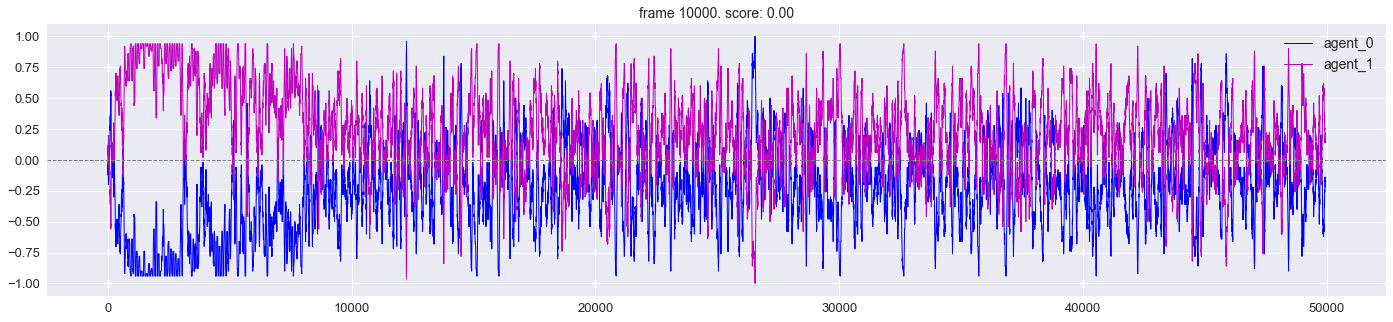

In [74]:
plot(10000, av_scores)

In [86]:
av_scores2 = {'agent_0':0, 'agent_1':0}
for sc in scores:
    av_scores2[sc] = moving_average(scores[sc], 50)

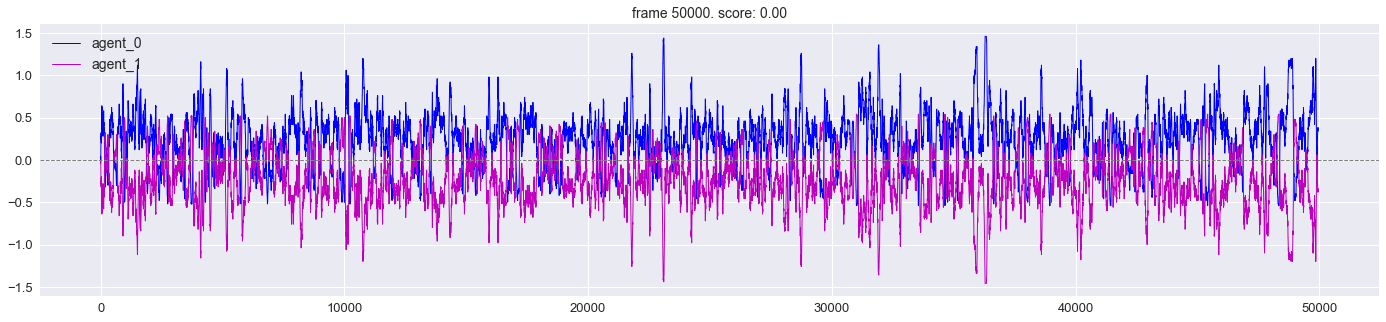

In [87]:
plot(50000, av_scores2)

In [13]:
def play(graphics=False, video_to_file=False):
    if video_to_file:
        import cv2
        frame_list = []

    maddpg.prep_rollouts(device='cpu')
    
    with torch.no_grad():
        for i_episode in range(1):
            
            env.reset()
            state = np.zeros((1, N_AGENTS) + OBS_DIM)
            action = np.zeros((1, N_AGENTS, ACT_DIM))
            reward =  np.zeros((N_AGENTS))
            next_state = np.zeros((1, N_AGENTS) + OBS_DIM)
            done = np.zeros((N_AGENTS))
            next_obs = [0,0]
            score = 0
            
            for t, wlkr in enumerate(env.agent_iter()):
                i_a = t % N_AGENTS

                next_obs[i_a], reward[i_a], done[i_a], _ = env.last()
                state[0, i_a] = np.swapaxes(next_obs[i_a]['observation'], 0, 2)
                if graphics:
                    if video_to_file:
                        frame = env.render(mode='rgb_array')
                        frame_list.append(deepcopy(frame))
                    else:
                        env.render()
                if done[i_a]:
                    if all(done):
                        env.close()
                        break
                    env.step(None)
                    continue

                torch_obs = Variable(torch.Tensor(state[0:1, i_a]), requires_grad=False)
                torch_mask = Variable(torch.Tensor((next_obs[i_a]['action_mask']-1) * 5 ), requires_grad=False)
                # get actions as torch Variables
                torch_agent_actions = maddpg.step(torch_obs, torch_mask, i_a, explore=False)
                # convert actions to numpy arrays
                action[0, i_a] = deepcopy(torch_agent_actions.data.numpy()[0])
                env.step(np.argmax(action[0, i_a]))

                score += reward[i_a] / N_AGENTS
                time.sleep(0.3)
            
            print(f'{score = :.2f}')
            env.reset()

        env.close()
    if video_to_file:
        out = cv2.VideoWriter(video_to_file+'.mp4',cv2.VideoWriter_fourcc(*'X264'), 50, (frame_list[0].shape[1] ,frame_list[0].shape[0]))
 
        for images in frame_list:
            out.write(cv2.cvtColor(np.array(images),cv2.COLOR_BGR2RGB))
        out.release()

## Load saved model

In [9]:
maddpg = MADDPG.init_from_save(MODEL_DIR + 'model_maddpg.pt')

# Render playing agents

In [25]:
play(True)

score = 0.00


# Play with agent

In [90]:
!python 4anim.py

[INFO   ] [Logger      ] Record log in C:\Users\otnie\.kivy\logs\kivy_21-09-05_0.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.3.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.3.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.3.1
[INFO   ] [Kivy        ] v2.0.0
[INFO   ] [Kivy        ] Installed at "D:\Programming\anaconda3\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "D:\Programming\anaconda3\python.exe"
[INFO   ] [Factory     ] 186 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil (img_ffpyplayer ignored)
[INFO   ] [Text        ] Provider: sdl2
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO   ] [GL          ] GLEW initialization succeeded
[INFO   ] [GL          ] Backend used <glew>
[INFO   ] [GL       

# Model info

In [91]:
from torchinfo import summary

In [99]:
print(maddpg.agents[0].policy)

MLPNetwork_CNN(
  (cnn1): Conv2d(2, 8, kernel_size=(2, 2), stride=(1, 1))
  (cnn2): Conv2d(8, 8, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=244, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=7, bias=True)
)


In [101]:
_=summary(maddpg.agents[0].policy, input_size=(1,2,7,6), col_names=["input_size","output_size","num_params"], verbose=1)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MLPNetwork_CNN                           --                        --                        --
├─Conv2d: 1-1                            [1, 2, 7, 6]              [1, 8, 6, 5]              72
├─Conv2d: 1-2                            [1, 8, 6, 5]              [1, 8, 5, 4]              264
├─Linear: 1-3                            [1, 244]                  [1, 50]                   12,250
├─Linear: 1-4                            [1, 50]                   [1, 50]                   2,550
├─Linear: 1-5                            [1, 50]                   [1, 50]                   2,550
├─Linear: 1-6                            [1, 50]                   [1, 7]                    357
Total params: 18,043
Trainable params: 18,043
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.08
